## Installing snntorch library

In [3]:
!pip install snntorch --quiet
!pip install -q kaggle
!pip install torchview -q
!pip install torchshape -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 3.7 MB/s eta 0:00:00


## Importing all the necessary tools

In [4]:
import numpy as np
import itertools
import cv2
from google.colab import files
import timeit
from os import listdir
import os
from zipfile import ZipFile
import gdown
import shutil

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchview import draw_graph
from torchvision.transforms import ToTensor
from torchshape import tensorshape

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.metrics import classification_report

## Loading data from web and arranging in the filesystem
Before running the following code, make sure that you have loaded the file "kaggle.json" into the working directory. It should contain your API key to Kaggle. Also make sure that you have agreed to the rules for using the fingertips dataset. 
[Link](https://www.kaggle.com/datasets/ruizgara/socofing) to the SOCOFing dataset.

Unfortunately, you will not be able to run the code for fingerprints classification without this file. However, you can still use EMNIST and Fashion-MNIST datasets.

In [5]:
# Load fingerprints dataset from kaggle
%%capture
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d ruizgara/socofing -q
!mkdir original_data
!unzip socofing.zip -d .

In [6]:
# Load fingerprints dataset from kaggle and sort it
# Sort data inside train and test folders on classes folders named from 0 to 9
map_finger_name = ['left_thumb', 'left_index', 'left_middle', 'left_ring', 'left_little',
           'right_thumb', 'right_index', 'right_middle', 'right_ring', 'right_little']

# Working directories
load_dir = 'SOCOFing/'

datadir = './datasets/'
finger_dir = datadir + 'fingerprints/'
finger_train_dir = finger_dir + 'train/'
finger_val_dir = finger_dir + 'val/'
finger_test_dir = finger_dir + 'test/'

if not os.path.exists(finger_dir):
    # Create folders
    os.mkdir('./datasets')
    os.mkdir(finger_dir)
    os.mkdir(finger_train_dir)
    os.mkdir(finger_val_dir)
    os.mkdir(finger_test_dir)

    # Create folders for each class
    for i in range(10):
        os.mkdir(finger_train_dir + f"{i}/")
        os.mkdir(finger_val_dir + f"{i}/")
        os.mkdir(finger_test_dir + f"{i}/")

    # Move and sort by classes files of train dataset
    # for dir in ['Real/', 'Altered/Altered-Easy/']:
    for dir in ['Real/', 'Altered/Altered-Easy/']:
        for img in os.listdir(load_dir + dir):
            ind = max([i if map_finger_name[i] in img.lower() else -1 for i in range(len(map_finger_name))])
            shutil.copy2(load_dir + dir + img, finger_train_dir + f"{ind}/" + img)


## Data preprocessing


In [7]:
# Transforms for fingerprints
class CropInvertPadTransform:
    """
    Crop the frame (2*2*4*4) from the image, reformat to 1 channel, invert colors 
    and put black padding to the squared form. If the size is bigger, than the required, resize it
    """
    def __init__(self, size):
        self.size = size
        

    def __call__(self, x):
        """
        Transform the image by frame cropping, grayscaling and inverting
        Resize to the square by adding black padding

        :param x: tensor (image) to be transformed
        :return: transformed image
        """
        # Crop the frame 2 2 4 4 pixels
        x = TF.crop(x, 2, 2, TF.get_image_size(x)[1] - 6, TF.get_image_size(x)[0] - 6)
        x = TF.rgb_to_grayscale(x)
        x = TF.invert(x)

        # Add black padding to make the image square
        a = max(TF.get_image_size(x)) - TF.get_image_size(x)[0]
        b = max(TF.get_image_size(x)) - TF.get_image_size(x)[1]

        x = TF.pad(x, [a // 2, b // 2, a - a // 2, b - b // 2], fill=0)
        if TF.get_image_size(x)[0] > self.size:
            x = TF.resize(x, [self.size, self.size], antialias=True)
        return x

In [8]:
# Set transformations of images
# Transformations for fingerprints
fingerprints_transform = transforms.Compose([
    transforms.ToTensor(),
    CropInvertPadTransform(97),
    transforms.Normalize((0,), (1,))
])
# Define a transform for emnist and fashion mnist
mnist_transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

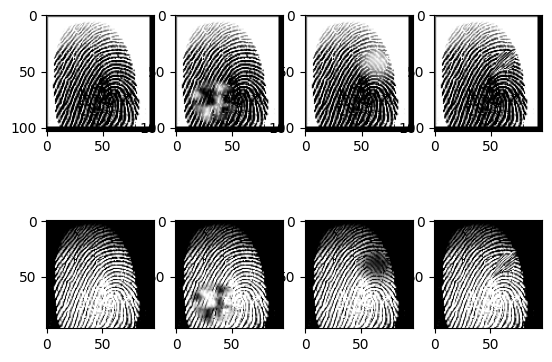

In [7]:
# Show example of fingerprint with alterations before and after transform
# Load the image
names = ['107__M_Left_index_finger.BMP', '107__M_Left_index_finger_Obl.BMP', '107__M_Left_index_finger_CR.BMP', '107__M_Left_index_finger_Zcut.BMP']

for i in range(len(names)):
    root='./datasets/fingerprints/'
    dirs = ['train/']
    for d in dirs:
        if names[i] in os.listdir(root+d+'1/'):
            break
    image = cv2.imread(finger_train_dir+'1/'+names[i])
    #Plot the original image
    plt.subplot(2, 4, i+1)
    # plt.title("Original")
    plt.imshow(image)

    #Plot the sharpened image
    plt.subplot(2, 4, i+5)
    
    arr = fingerprints_transform(image)[0].numpy()*255    
    plt.imshow(arr,cmap='gray')

plt.show()

### Transform - Datasets - Dataloaders

In [9]:
# Directories of datasets
datadir = './datasets/'
finger_dir = datadir + 'fingerprints/'
finger_train_dir = finger_dir + 'train/'
emnist_dir = datadir + 'emnist/'
fashion_dir = datadir + 'fashion_mnist/'

train_dir = 'train/'
val_dir = 'val/'
test_dir = 'test/'

# Split proportions
val_split = 0.1
test_split = 0.1
batch_size = 128

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
# Fingerprints

# Split on validation and test split
for finger_type in os.listdir(finger_train_dir):
    imgs = os.listdir(finger_train_dir + finger_type)
    # Split with shuffling
    np.random.shuffle(imgs)
    for img in imgs[:int(len(imgs) * test_split) + 1]:
        os.rename(finger_train_dir + finger_type + "/" + img, finger_dir + test_dir + finger_type + "/" + img)

    for img in imgs[int(len(imgs) * test_split) + 1:int(len(imgs) * test_split) + int(len(imgs) * val_split) + 2]:
        os.rename(finger_train_dir + finger_type + "/" + img, finger_dir + val_dir + finger_type + "/" + img)


# Set dataset
fingerprints_dataset = {'train': datasets.ImageFolder(root=finger_dir+train_dir, transform=fingerprints_transform),
                        'val': datasets.ImageFolder(root=finger_dir+val_dir, transform=fingerprints_transform),
                        'test': datasets.ImageFolder(root=finger_dir+test_dir, transform=fingerprints_transform)
}

# Set dataloader
fingerprints_dataloader = {'train': DataLoader(fingerprints_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                        'val': DataLoader(fingerprints_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                        'test': DataLoader(fingerprints_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}

In [13]:
# EMNIST
# Set dataset
emnist_dataset = {'train': torchvision.datasets.EMNIST(emnist_dir+train_dir, 'digits', download=True, train=True, transform=mnist_transform),
                  'val': None,
                  'test': torchvision.datasets.EMNIST(emnist_dir+train_dir, 'digits',download=True, train=False, transform=mnist_transform)
}

# Validation split
emnist_dataset['train'], emnist_dataset['val'] = random_split(emnist_dataset['train'], [1-val_split, val_split])

# Set dataloaders
emnist_dataloader = {'train': DataLoader(emnist_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'val': DataLoader(emnist_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'test': DataLoader(emnist_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}


100%|██████████| 561753746/561753746 [00:27<00:00, 20572675.74it/s]


Extracting ./datasets/emnist/train/EMNIST/raw/gzip.zip to ./datasets/emnist/train/EMNIST/raw


In [14]:
# Fashion-MNIST
# Set dataset
fashion_dataset = {'train': torchvision.datasets.FashionMNIST(fashion_dir+train_dir, download=True, train=True, transform=mnist_transform),
                  'val': None,
                  'test': torchvision.datasets.FashionMNIST(fashion_dir+train_dir, download=True, train=False, transform=mnist_transform)
}

# Validation split
fashion_dataset['train'], fashion_dataset['val'] = random_split(fashion_dataset['train'], [1-val_split, val_split])

# Set dataloaders
fashion_dataloader = {'train': DataLoader(fashion_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'val': DataLoader(fashion_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'test': DataLoader(fashion_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}


100%|██████████| 26421880/26421880 [00:14<00:00, 1822374.96it/s]


Extracting ./datasets/fashion_mnist/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 119360.17it/s]


Extracting ./datasets/fashion_mnist/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 482136.91it/s] 


Extracting ./datasets/fashion_mnist/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5897917.78it/s]

Extracting ./datasets/fashion_mnist/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST/raw



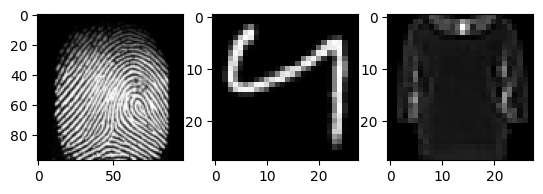

In [ ]:
# Print one picture from each dataset
dataloaders = [fingerprints_dataloader, emnist_dataloader, fashion_dataloader]
for i in range(3):
    pic, _ = next(iter(dataloaders[i]['train']))
    pic = pic[0][0].numpy()*255 

    plt.subplot(1, 3, i+1)
    plt.imshow(pic, cmap='gray')

plt.show()

## Animations and visualizations of dataset

#### Rate coding

Spiking neural networks are designed to handle time-varying data. In this case, to use spike-based communication in the network, the input data should be encoded from the continuous value form into a time series of spikes.

In rate coding, each normalized value of input features is used to compute the probability that a spike will occur at any given time step, resulting in a discrete rate-encoded value. One may consider this as a Binomial distribution with number of trials equal to 1 and a probability of success (spike) equal to the normalized value of input feature.

In [15]:
%%capture
%matplotlib inline

# Batch of images from each dataset
img_finger, label_finger = next(iter(fingerprints_dataloader['train'])) 
img_e, label_e = next(iter(emnist_dataloader['train'])) 
img_fash, label_fash = next(iter(fashion_dataloader['train'])) 

# First image in the batch of images
img_finger, img_e, img_fash = img_finger[0][0], img_e[0][0], img_fash[0][0] 

# Set number of time steps and prbability of spike for most intensive pixel
num_steps = 100
gain = 1

# Encode image with rate coding
encoded_img_finger = spikegen.rate(img_finger, num_steps=num_steps, gain=gain)
encoded_img_e = spikegen.rate(img_e, num_steps=num_steps, gain=gain)
encoded_img_fash = spikegen.rate(img_fash, num_steps=num_steps, gain=gain)

# Base frame of image
fig, ax = plt.subplots(1,3, figsize = (12,4))
plt.tight_layout()
image_plot_finger = ax[0].imshow(img_finger, cmap='gray')
image_plot_e = ax[1].imshow(img_e, cmap='gray')
image_plot_fash = ax[2].imshow(img_fash, cmap='gray')

def init():
    """
    Initialization function
    Plot the background of each frame

    """
    image_plot_finger.set_data(img_finger)
    image_plot_e.set_data(img_e)
    image_plot_fash.set_data(img_fash)
    for x in ax:
      x.set_axis_off()
      
def animate(time):
    """
    Animation function; called sequantially

    :param time: time step
    """
    image_plot_finger.set_array(encoded_img_finger[time])
    image_plot_e.set_array(encoded_img_e[time])
    image_plot_fash.set_array(encoded_img_fash[time])
    ax[0].set_title(f'Fingerprint')
    ax[1].set_title(f'EMNIST')
    ax[2].set_title(f'Fashion-MNIST')

anim = FuncAnimation(fig, animate, init_func=init, frames=len(encoded_img_fash), interval=100)

In [ ]:
HTML(anim.to_html5_video())

#### Raster plot of diagonal pixels for fingerprint

Spike-coded images can be represented in form of raster plot, showing spikes of pixels at each time step

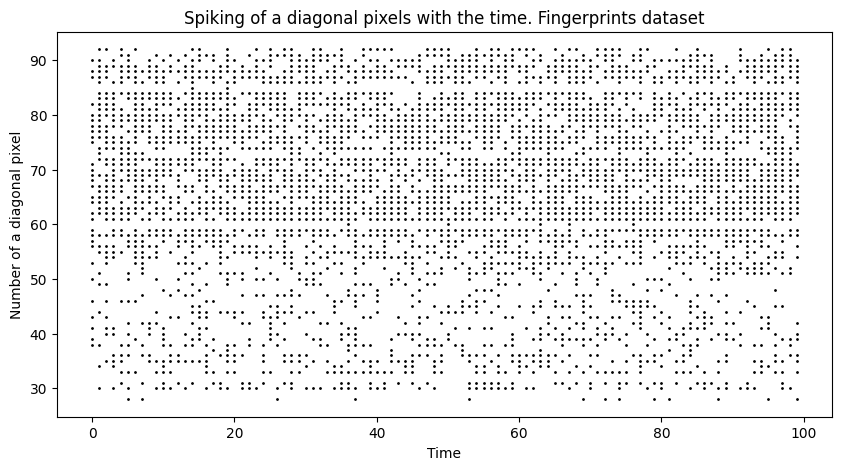

In [17]:
# Reshape image
raster_img = torch.Tensor([encoded_img_finger[:,i,i].numpy() for i in range(len(encoded_img_finger[0]))]).T

# Raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title('Spiking of a diagonal pixels with the time. Fingerprints dataset')
ax.set_xlabel('Time')
ax.set_ylabel('Number of a diagonal pixel')
splt.raster(raster_img, ax, s=1, color='black')

#### Membrane's potential

Leaky Integrate-and-Fire (LIF) neuron receives the sum of the weighted input signals. LIF integrates the inputs over time. If the integrated value exceeds a predefined threshold, the LIF neuron produces a spike.

As a result, the information is not stored in spikes, but rather in its frequency.

We plotted the behavior of an LIF neuron receiving input spikes over 100 time steps.

In [29]:
def add_x_ticks(ax):
    """
    Adding ticks

    :param ax: Axes object
    """ 
    ax.set_xticks(list(range(100))[::1])
    ax.tick_params(axis='x', which='major', labelsize=7)
    ax.set_yticks([])

def plot_spikes_with_potential(spikes, in_spikes, potential, 
                               title=None, threshold=1):
    """
    Plot input, output spikes and membrane potential

    :param spikes: output spikes
    :param in_spikes: input spikes
    :param potential: membrane potential
    :param title: title of plot
    :param threshold: value of threshold for membrane potential
    """
    # Unpacking Figure and Axes array
    fig, ax = plt.subplots(3,1, facecolor="w", figsize=(15, 5),
                          gridspec_kw={'height_ratios': [0.5, 4, 0.5]})
    ax[2].autoscale(tight=True)
    ax[1].autoscale(tight=True)
    ax[0].autoscale(tight=True)

    # Input spikes
    ax[0].set_title(f"{int(spikes.sum())} spikes and potential in neuron" if title==None else title)
    ax[0].set_ylabel("Input spikes")
    splt.raster(in_spikes, ax[0], s=200, c="black", marker="|")
    add_x_ticks(ax[0])

    # Output spikes
    splt.raster(spikes, ax[2], s=200, c="black", marker="|")
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Output spikes")
    add_x_ticks(ax[2])

    # Membrane potential
    ax[1].plot(potential)
    ax[1].set_ylabel("Membrane potential")
    add_x_ticks(ax[1])

    times = []
    for i,spike in enumerate(spikes):
      if (spike != 0):
        times.append(i)

    ax[1].vlines(x = times, ymin = potential.min(), ymax = potential.max(), 
                 colors = 'gray', ls='dashed', lw=0.5)

    # Threshold line
    ax[1].axhline(y = threshold, color = 'r', linestyle = '--')

    fig.tight_layout()

In [31]:
# Leaky Integrate-and-Fire neuron
delta_t = 1e-3
tau = 5.1*5e-3
b = np.exp(-delta_t/tau)
lif = snn.Leaky(beta = b, threshold = 1.5)

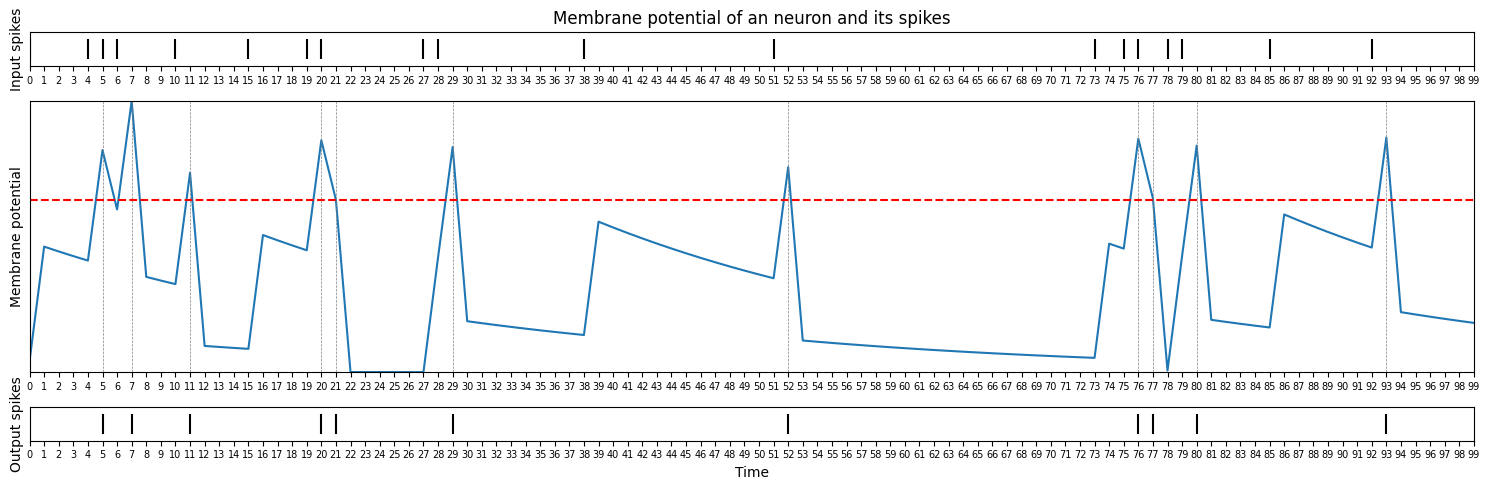

In [32]:
# Initialize input, output spikes and membrane potential
spk_in = spikegen.rate_conv(torch.ones((99))*0.2)
mem = torch.ones(1)*0.1
spk = torch.zeros(1)
potential = [mem]
spikes = [spk]

# Neuron simulation
for step in range(99):
  spk, mem = lif(spk_in[step], mem)
  potential.append(mem)
  spikes.append(spk)

# Plot the spikes and membrane potential
potential = torch.stack(potential)
spikes = torch.stack(spikes)
plot_spikes_with_potential(spikes, spk_in, potential, 
                           title='Membrane potential of an neuron and its spikes', 
                           threshold = 1.5)

# Experiments

In [12]:
def training(model, train_loader, val_loader, optimizer, criterion, 
             device, epochs, tolerance = 3, min_delta = 0.01, 
             snn_mode = False, num_steps = None, path_load_model="model.pt"):
    """
    Training of model

    :param model: model to be trained
    :param train_loader: dataloader with train dataset
    :param val_loader: dataloader with validation dataset
    :param optimizer: optimizer
    :param criterion: loss function
    :param device: device on with model run
    :param epochs: number of epochs to be trained
    :param tolerance: number of epochs for stopping criteria
    :param min_delta: min validation loss delta between epochs for stopping criteria
    :param snn_mode: True - SNN training, False - ANN training
    :param num_steps: number of time steps for SNN
    :param path_load_model: path to save trained model
    :return: validation loss and accuracy history, time per epoch
    """
    epochs = epochs
    num_steps = num_steps
    time_delta = 0
    total_val_history = []
    accuracy_history = []
    best_accuracy = 0

    count = 0
    early_stop_val = np.inf
    
    start = timeit.default_timer()

    for epoch in range(epochs):
        # For "epochs" number of epochs
        model.train()

        train_loss, valid_loss = [], []
        total_train = 0
        correct_train = 0
        total_val = 0
        correct_val = 0

        for data, targets in train_loader:
            # For each batch of training set

            # Transfer to device
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            
            
            if snn_mode:
                # For SNN models
                # Reshape data
                data = data.view(data.shape[0], -1)

                # Run model on batch and return output spike and membrane potential
                spike, potential = model(data)

                # Training loss of batch
                loss_val = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    loss_val += criterion(potential[step], targets)

                # Mean training loss
                loss_val /= num_steps

                # Decode output spikes to real-valued label
                _, predicted = spike.sum(dim=0).max(1)

                # Count number targets and correct identified labels
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()
            else:
                # For ANN models
                output = model(data)

                # Training loss of batch
                loss_val = criterion(output, targets)

                # Decode output spikes to real-valued label
                pred = output.argmax(dim=1, keepdim=True) 

                # Count number targets and correct identified labels
                total_train += targets.size(0)
                correct_train += pred.eq(targets.view_as(pred)).sum().item()

            # For next epoch
            loss_val.backward()
            optimizer.step()
            train_loss.append(loss_val.item())

        with torch.no_grad():
            # Validation phase
            model.eval()

            for data, targets in val_loader:
                # For each batch of validation set
                data = data.to(device)
                targets = targets.to(device)
                
                if snn_mode:
                    # For SNN models
                    # Reshape data
                    data = data.view(data.shape[0], -1)

                    # Run model on batch and return output spike and membrane potential
                    spike, potential = model(data)

                    # Validation loss of batch
                    loss_val = torch.zeros((1), dtype=dtype, device=device)
                    for step in range(num_steps):
                        loss_val += criterion(potential[step], targets)

                    # Mean validation loss
                    loss_val /= num_steps

                    # Decode output spikes to real-valued label
                    _, predicted = spike.sum(dim=0).max(1)

                    # Count number targets and correct identified labels
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()

                else:
                    # For ANN models
                    output = model(data)

                    # Validation loss of batch
                    loss_val = criterion(output, targets)
                    
                    # Decode output spikes to real-valued label
                    pred = output.argmax(dim=1, keepdim=True) 

                    # Count number targets and correct identified labels
                    total_val += targets.size(0)
                    correct_val += pred.eq(targets.view_as(pred)).sum().item()

                valid_loss.append(loss_val.item())

            # Early stopping
            if abs(early_stop_val - np.mean(valid_loss)) < min_delta:
                count += 1
            else:
                count = 0
            if count == tolerance:
                break

            early_stop_val = np.mean(train_loss)

            # Total validation loss and accuracy
            total_val_history.append(np.mean(valid_loss))
            accuracy_history.append(correct_val/total_val)

            # Save best model
            if best_accuracy <= accuracy_history[-1]:
                torch.save(model.state_dict(), path_load_model)

            print ("Epoch:", epoch, "\n\tTraining Loss:", np.mean(train_loss), 
                f"\n\tTraining Accuracy: {100 * correct_train/total_train:.2f}%", 
                "\n\tValidation Loss:", np.mean(valid_loss),
                f"\n\tValidation Accuracy: {100 * correct_val/total_val:.2f}%")
            
    stop = timeit.default_timer()
    time_delta = stop - start
    return total_val_history, accuracy_history, time_delta/(epoch + 1)


def testing(model, test_loader, device, snn_mode = False):
    """
    Testing of model

    :param model: model to be trained
    :param test_loader: dataloader with test dataset
    :param device: device on with model run
    :param snn_mode: True - SNN training, False - ANN training
    :return: true labels and predictions
    """
    total = 0
    correct = 0
    predictions = np.array([])
    true_labels = np.array([])

    with torch.no_grad():
        model.eval()
        for data, targets in test_loader:
            # For batch in test set
            data = data.to(device)
            targets = targets.to(device)
            
            if snn_mode:
                # SNN model
                # Output spikes
                test_spk, _ = model(data.view(data.size(0), -1))

                # Decode output spikes to real-valued label
                _, predicted = test_spk.sum(dim=0).max(1)
                predictions = np.concatenate((predictions, predicted.cpu()))
            

                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            else:
                # ANN model
                output = model(data)

                predicted = output.argmax(dim=1, keepdim=True) 
                predictions = np.concatenate((predictions, predicted.cpu().numpy().reshape(1,-1)[0]))
            
                
                # Count number targets and correct identified labels
                total += targets.size(0)
                correct += predicted.eq(targets.view_as(predicted)).sum().item()

            true_labels = np.concatenate((true_labels, targets.cpu()))

    print(f"Total correctly classified test set images: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%\n")
    return true_labels, predictions

In [13]:
class SNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, 
                 num_hidden = 1024, num_steps = 25, 
                 beta = 0.95):
        """
        SNN with one hidden layer

        :param num_inputs: number of input units
        :param num_outputs: number of output units
        :param num_hidden: number of hidden units
        :param num_steps: number of time steps
        :param beta: beta coefficient value for Leaky model
        """
        super(SNN, self).__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        # Initialize number of time steps
        self.num_steps = num_steps

    def forward(self, x):
        """
        Forward step

        :param x: input values
        :return: output spikes and membrane potential
        """
        # Initialize hidden states at t=0
        potential1 = self.lif1.init_leaky()
        potential2 = self.lif2.init_leaky()
        
        # Record the output values
        output_spike = []
        output_potential = []

        for step in range(self.num_steps):
            # For each time step run through the SNN
            current1 = self.linear1(x)
            spike1, potential1 = self.lif1(current1, potential1)
            current2 = self.linear2(spike1)
            spike2, potential2 = self.lif2(current2, potential2)
            
            # Record outputs
            output_spike.append(spike2)
            output_potential.append(potential2)
        return torch.stack(output_spike, dim=0), torch.stack(output_potential, dim=0)

In [14]:
class CNN(nn.Module):
    def __init__(self, inputs_shape=(128, 1,97,97), num_outputs=10, 
                 num_hidden = 1024):
        """
        CNN with one fully-connected hidden layer

        :param inputs_shape: input shape of image
        :param num_outputs: number of output units
        :param num_hidden: number of hidden units
        """
        super(CNN, self).__init__()

        # First convolutional and max-pooling block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Second convolutional and max-pooling block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Output shape
        outshape = [*tensorshape(self.conv2, tensorshape(self.conv1, inputs_shape))][1:]

        # Linear block
        self.linear1 = nn.Sequential(
            nn.Linear(np.prod(outshape), num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_outputs)
        )

    def forward(self, x):
        """
        Forward step

        :param x: input values
        :return: output values
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)

## Create models for different datasets


In [15]:
# Set parameters common for all models
max_epochs = 20
time_steps = 25
criterion = nn.CrossEntropyLoss

load_path =  "./save_model/"
if not os.path.exists(load_path):
    os.mkdir(load_path)

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'Device: {device}')

Device: cuda


### Fingerprints 



#### Create models

In [16]:
# Set parameters for this dataset

# Set input and output shapes
finger_input_shape = next(iter(fingerprints_dataloader['train']))[0].shape
finger_num_inputs = np.prod(finger_input_shape[-2:])
finger_num_outputs = len(np.unique(fingerprints_dataloader['train'].dataset.targets))

# Set path where to load the models
finger_snn_load_path = load_path + "finger_snn_model.pt"
finger_cnn_load_path = load_path + "finger_cnn_model.pt"

In [ ]:
# Create SNN model
finger_snn = SNN(finger_num_inputs, finger_num_outputs).to(device)
finger_snn_optimizer = torch.optim.Adam(finger_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(finger_snn)

SNN(
  (linear1): Linear(in_features=9409, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Train SNN model
finger_snn_loss, finger_snn_accuracy, finger_snn_time = training(finger_snn, fingerprints_dataloader['train'], 
                                  fingerprints_dataloader['val'], finger_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=finger_snn_load_path)

Epoch: 0 
	Training Loss: 1.926117940237058 
	Training Accuracy: 37.53% 
	Validation Loss: 1.7074615557988484 
	Validation Accuracy: 46.48%
Epoch: 1 
	Training Loss: 1.560502977179201 
	Training Accuracy: 53.43% 
	Validation Loss: 1.5396610365973578 
	Validation Accuracy: 54.73%
Epoch: 2 
	Training Loss: 1.2884122405276202 
	Training Accuracy: 66.11% 
	Validation Loss: 1.348921709590488 
	Validation Accuracy: 64.02%
Epoch: 3 
	Training Loss: 1.0516768841935484 
	Training Accuracy: 77.09% 
	Validation Loss: 1.1251484155654907 
	Validation Accuracy: 72.35%
Epoch: 4 
	Training Loss: 0.8411731187929243 
	Training Accuracy: 85.71% 
	Validation Loss: 0.9412186278237237 
	Validation Accuracy: 80.30%
Epoch: 5 
	Training Loss: 0.6728735506134546 
	Training Accuracy: 91.09% 
	Validation Loss: 0.833050419886907 
	Validation Accuracy: 84.90%
Epoch: 6 
	Training Loss: 0.529894294154724 
	Training Accuracy: 94.50% 
	Validation Loss: 0.6802046464549171 
	Validation Accuracy: 89.06%
Epoch: 7 
	Trainin

In [ ]:
# Create CNN model
finger_cnn = CNN(finger_input_shape, finger_num_outputs).to(device)
finger_cnn_optimizer = torch.optim.Adam(finger_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(finger_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=15488, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# Train CNN model
finger_cnn_loss, finger_cnn_accuracy, finger_cnn_time = training(finger_cnn, fingerprints_dataloader['train'], 
                                  fingerprints_dataloader['val'], finger_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=finger_cnn_load_path)

Epoch: 0 
	Training Loss: 1.7840364803403816 
	Training Accuracy: 37.33% 
	Validation Loss: 1.5134804844856262 
	Validation Accuracy: 46.96%
Epoch: 1 
	Training Loss: 1.4142276064661525 
	Training Accuracy: 50.28% 
	Validation Loss: 1.3603572580549452 
	Validation Accuracy: 51.82%
Epoch: 2 
	Training Loss: 1.2774872995863025 
	Training Accuracy: 54.85% 
	Validation Loss: 1.2750739985042148 
	Validation Accuracy: 54.12%
Epoch: 3 
	Training Loss: 1.1940705436188102 
	Training Accuracy: 57.72% 
	Validation Loss: 1.180422259701623 
	Validation Accuracy: 57.94%
Epoch: 4 
	Training Loss: 1.1230982686049187 
	Training Accuracy: 60.21% 
	Validation Loss: 1.1368703246116638 
	Validation Accuracy: 60.07%
Epoch: 5 
	Training Loss: 1.0750131483046002 
	Training Accuracy: 61.93% 
	Validation Loss: 1.0746352109644148 
	Validation Accuracy: 61.63%
Epoch: 6 
	Training Loss: 1.019168625741997 
	Training Accuracy: 64.43% 
	Validation Loss: 1.041393670770857 
	Validation Accuracy: 62.76%
Epoch: 7 
	Train

#### Load the best obtained models

In [ ]:
# Load SNN model
finger_snn = SNN(finger_num_inputs, finger_num_outputs)
finger_snn.load_state_dict(torch.load(finger_snn_load_path))
finger_snn.to(device)

print(finger_snn)

SNN(
  (linear1): Linear(in_features=9409, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Load CNN model
finger_cnn = CNN(finger_input_shape, finger_num_outputs)
finger_cnn.load_state_dict(torch.load(finger_cnn_load_path))
finger_cnn.to(device)

print(finger_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=15488, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [ ]:
print("Average time per epoch for SNN:", finger_snn_time, end=" sec\n")
print(classification_report(*testing(finger_snn, fingerprints_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 31.189757905149985 sec 
Total correctly classified test set images: 2272/2304 
Test Set Accuracy: 98.61% 
               precision    recall  f1-score   support
 
          0.0       0.99      0.99      0.99       233
          1.0       0.98      0.99      0.98       231
          2.0       1.00      0.99      0.99       231
          3.0       1.00      0.98      0.99       224
          4.0       0.97      1.00      0.98       235
          5.0       0.96      0.99      0.98       232
          6.0       0.99      0.97      0.98       232
          7.0       0.98      1.00      0.99       232
          8.0       1.00      0.97      0.98       229
          9.0       1.00      0.99      0.99       225
 
     accuracy                           0.99      2304
    macro avg       0.99      0.99      0.99      2304
 weighted avg       0.99      0.99      0.99      2304



In [ ]:
print("Average time per epoch for CNN:", finger_cnn_time, end=" sec\n")
print(classification_report(*testing(finger_cnn, fingerprints_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 23.858707890899996 sec
Total correctly classified test set images: 1915/2304 
Test Set Accuracy: 83.12%
 
               precision    recall  f1-score   support
 
          0.0       0.96      0.93      0.94       230
          1.0       0.75      0.86      0.80       232
          2.0       0.80      0.75      0.78       232
          3.0       0.84      0.66      0.74       230
          4.0       0.83      0.80      0.82       230
          5.0       0.96      0.97      0.97       226
          6.0       0.80      0.91      0.85       234
          7.0       0.89      0.73      0.80       231
          8.0       0.75      0.83      0.79       229
          9.0       0.77      0.86      0.81       230
 
     accuracy                           0.83      2304
    macro avg       0.84      0.83      0.83      2304
 weighted avg       0.84      0.83      0.83      2304



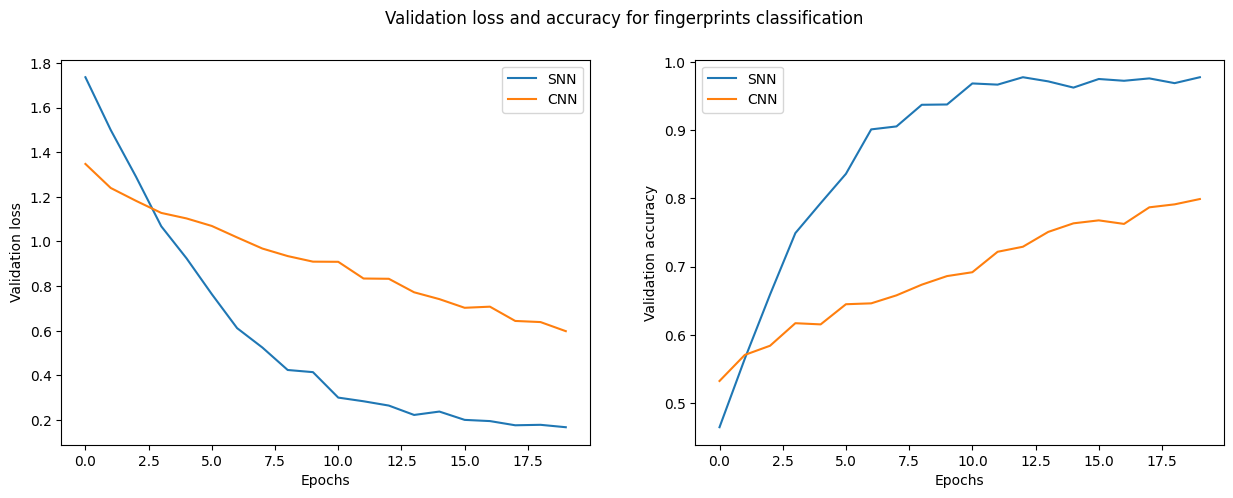

In [ ]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(finger_snn_loss)
plt.plot(finger_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(finger_snn_accuracy)
plt.plot(finger_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for fingerprints classification')
plt.show()

### EMNIST 



#### Create models

In [17]:
# Set parameters for this dataset

# Set input and output shapes
emnist_input_shape = next(iter(emnist_dataloader['train']))[0].shape
emnist_num_inputs = np.prod(emnist_input_shape[-2:])
emnist_num_outputs = len(np.unique(emnist_dataloader['test'].dataset.targets))

# Set path where to load the models
emnist_snn_load_path = load_path + "emnist_snn_model.pt"
emnist_cnn_load_path = load_path + "emnist_cnn_model.pt"

In [18]:
# Create SNN model
emnist_snn = SNN(emnist_num_inputs, emnist_num_outputs).to(device)
emnist_snn_optimizer = torch.optim.Adam(emnist_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(emnist_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Train SNN model
emnist_snn_loss, emnist_snn_accuracy, emnist_snn_time = training(emnist_snn, emnist_dataloader['train'], 
                                  emnist_dataloader['val'], emnist_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=emnist_snn_load_path)

Epoch: 0 
	Training Loss: 0.3817740789993882 
	Training Accuracy: 89.22% 
	Validation Loss: 0.22210720898633335 
	Validation Accuracy: 93.86%
Epoch: 1 
	Training Loss: 0.18616511481060527 
	Training Accuracy: 95.56% 
	Validation Loss: 0.16425262100715687 
	Validation Accuracy: 96.52%
Epoch: 2 
	Training Loss: 0.14079996567632436 
	Training Accuracy: 97.32% 
	Validation Loss: 0.13362869401188457 
	Validation Accuracy: 97.75%
Epoch: 3 
	Training Loss: 0.11617417303402536 
	Training Accuracy: 97.92% 
	Validation Loss: 0.11523723470814087 
	Validation Accuracy: 97.95%
Epoch: 4 
	Training Loss: 0.09906558542074576 
	Training Accuracy: 98.32% 
	Validation Loss: 0.10760783559498302 
	Validation Accuracy: 98.24%
Epoch: 5 
	Training Loss: 0.08560336935905288 
	Training Accuracy: 98.60% 
	Validation Loss: 0.09913049809594843 
	Validation Accuracy: 98.46%


In [22]:
# Create CNN model
emnist_cnn = CNN(emnist_input_shape, emnist_num_outputs).to(device)
emnist_cnn_optimizer = torch.optim.Adam(emnist_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(emnist_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# Train CNN model
emnist_cnn_loss, emnist_cnn_accuracy, emnist_cnn_time = training(emnist_cnn, emnist_dataloader['train'], 
                                  emnist_dataloader['val'], emnist_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=emnist_cnn_load_path)

Epoch: 0 
	Training Loss: 0.32576409916470195 
	Training Accuracy: 92.21% 
	Validation Loss: 0.09463100519808218 
	Validation Accuracy: 97.36%
Epoch: 1 
	Training Loss: 0.07497682473685749 
	Training Accuracy: 97.88% 
	Validation Loss: 0.05827153573699176 
	Validation Accuracy: 98.41%
Epoch: 2 
	Training Loss: 0.0501505772105104 
	Training Accuracy: 98.54% 
	Validation Loss: 0.043461156075192804 
	Validation Accuracy: 98.81%
Epoch: 3 
	Training Loss: 0.04011931505758662 
	Training Accuracy: 98.81% 
	Validation Loss: 0.03843539588795825 
	Validation Accuracy: 98.89%
Epoch: 4 
	Training Loss: 0.03366340825882937 
	Training Accuracy: 99.01% 
	Validation Loss: 0.03319755472730905 
	Validation Accuracy: 99.11%
Epoch: 5 
	Training Loss: 0.029641897011565947 
	Training Accuracy: 99.12% 
	Validation Loss: 0.03246446760348916 
	Validation Accuracy: 99.08%


#### Load best obtained models

In [ ]:
# Load SNN model
emnist_snn = SNN(emnist_num_inputs, emnist_num_outputs)
emnist_snn.load_state_dict(torch.load(emnist_snn_load_path))
emnist_snn.to(device)

print(emnist_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Load CNN model
emnist_cnn = CNN(emnist_input_shape, emnist_num_outputs)
emnist_cnn.load_state_dict(torch.load(emnist_cnn_load_path))
emnist_cnn.to(device)

print(emnist_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [ ]:
print("Average time per epoch for SNN:", emnist_snn_time, end=" sec\n")
print(classification_report(*testing(emnist_snn, emnist_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 149.19130589014281 sec
Total correctly classified test set images: 39303/39936
Test Set Accuracy: 98.41%
 
               precision    recall  f1-score   support
 
          0.0       0.97      0.99      0.98      3997
          1.0       0.99      0.99      0.99      3997
          2.0       0.99      0.99      0.99      3988
          3.0       0.96      0.99      0.97      3992
          4.0       0.99      0.99      0.99      3994
          5.0       0.99      0.97      0.98      3997
          6.0       0.99      0.98      0.99      3989
          7.0       0.99      0.98      0.98      3994
          8.0       0.99      0.98      0.98      3996
          9.0       0.98      0.98      0.98      3992
 
     accuracy                           0.98     39936
    macro avg       0.98      0.98      0.98     39936
 weighted avg       0.98      0.98      0.98     39936
 



In [ ]:
print("Average time per epoch for CNN:", emnist_cnn_time, end=" sec\n")
print(classification_report(*testing(emnist_cnn, emnist_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 79.05120787671434 sec
Total correctly classified test set images: 39629/39936
Test Set Accuracy: 99.23%
 
               precision    recall  f1-score   support
 
          0.0       0.99      1.00      0.99      3993
          1.0       1.00      0.99      1.00      3996
          2.0       0.99      0.99      0.99      3988
          3.0       0.99      0.99      0.99      3993
          4.0       0.99      0.99      0.99      3992
          5.0       0.99      0.99      0.99      3990
          6.0       1.00      0.99      0.99      3998
          7.0       0.99      0.99      0.99      3995
          8.0       0.99      0.98      0.99      3997
          9.0       0.99      0.99      0.99      3994
 
     accuracy                           0.99     39936
    macro avg       0.99      0.99      0.99     39936
 weighted avg       0.99      0.99      0.99     39936



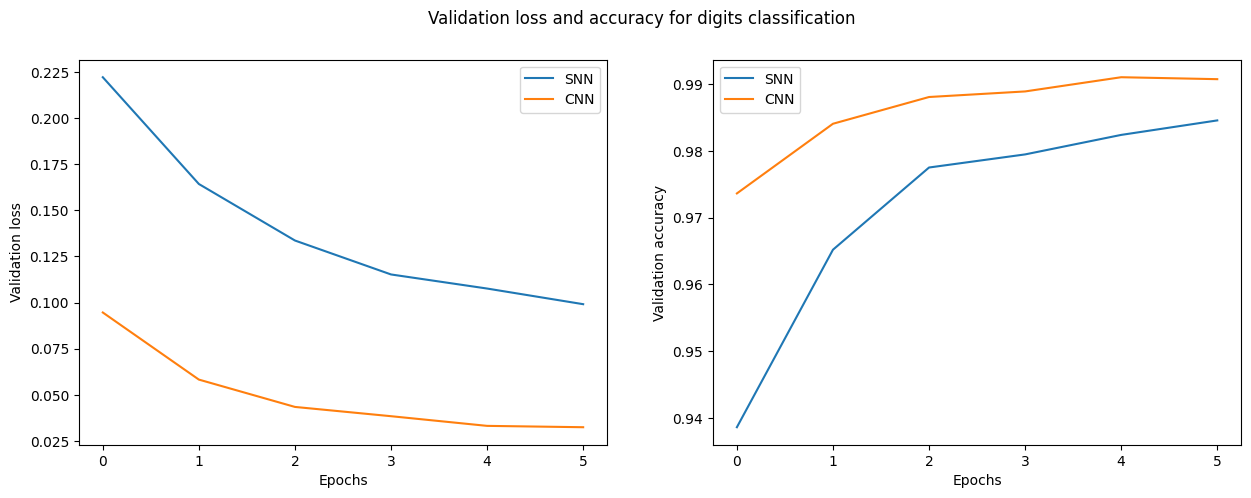

In [ ]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(emnist_snn_loss)
plt.plot(emnist_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(emnist_snn_accuracy)
plt.plot(emnist_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for digits classification')
plt.show()

### Fashion MNIST



#### Create models

In [33]:
# Set parameters for this dataset

# Set input and output shapes
fashion_input_shape = next(iter(fashion_dataloader['train']))[0].shape
fashion_num_inputs = np.prod(fashion_input_shape[-2:])
fashion_num_outputs = len(np.unique(fashion_dataloader['test'].dataset.targets))

# Set path where to load the models
fashion_snn_load_path = load_path + "fashion_snn_model.pt"
fashion_cnn_load_path = load_path + "fashion_cnn_model.pt"

In [34]:
# Create SNN model
fashion_snn = SNN(fashion_num_inputs, fashion_num_outputs).to(device)
fashion_snn_optimizer = torch.optim.Adam(fashion_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(fashion_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Train SNN model
fashion_snn_loss, fashion_snn_accuracy, fashion_snn_time = training(fashion_snn, fashion_dataloader['train'], 
                                  fashion_dataloader['val'], fashion_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=fashion_snn_load_path)

Epoch: 0 
	Training Loss: 0.8357130434903849 
	Training Accuracy: 69.45% 
	Validation Loss: 0.6444022253803585 
	Validation Accuracy: 75.87%
Epoch: 1 
	Training Loss: 0.5862254102552872 
	Training Accuracy: 76.79% 
	Validation Loss: 0.5580014664193859 
	Validation Accuracy: 77.77%
Epoch: 2 
	Training Loss: 0.526909024939118 
	Training Accuracy: 79.34% 
	Validation Loss: 0.5069939209067303 
	Validation Accuracy: 81.93%
Epoch: 3 
	Training Loss: 0.49475109499310654 
	Training Accuracy: 81.44% 
	Validation Loss: 0.5109762575315393 
	Validation Accuracy: 81.10%
Epoch: 4 
	Training Loss: 0.4750768264087532 
	Training Accuracy: 82.60% 
	Validation Loss: 0.47045269738072937 
	Validation Accuracy: 83.51%
Epoch: 5 
	Training Loss: 0.45930481084452107 
	Training Accuracy: 83.91% 
	Validation Loss: 0.45903320092221966 
	Validation Accuracy: 84.43%
Epoch: 6 
	Training Loss: 0.4463327810911555 
	Training Accuracy: 85.32% 
	Validation Loss: 0.4512438644533572 
	Validation Accuracy: 85.44%
Epoch: 7 


In [27]:
# Create CNN model
fashion_cnn = CNN(fashion_input_shape, fashion_num_outputs).to(device)
fashion_cnn_optimizer = torch.optim.Adam(fashion_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(fashion_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [ ]:
# Train CNN model
fashion_cnn_loss, fashion_cnn_accuracy, fashion_cnn_time = training(fashion_cnn, fashion_dataloader['train'], 
                                  fashion_dataloader['val'], fashion_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=fashion_cnn_load_path)

Epoch: 0 
	Training Loss: 1.0375571549646645 
	Training Accuracy: 67.65% 
	Validation Loss: 0.6514958084925361 
	Validation Accuracy: 75.90%
Epoch: 1 
	Training Loss: 0.5841187959328966 
	Training Accuracy: 78.16% 
	Validation Loss: 0.5440635182287382 
	Validation Accuracy: 79.31%
Epoch: 2 
	Training Loss: 0.5155838298967502 
	Training Accuracy: 80.80% 
	Validation Loss: 0.5104718836753265 
	Validation Accuracy: 80.79%
Epoch: 3 
	Training Loss: 0.47886138842961 
	Training Accuracy: 82.39% 
	Validation Loss: 0.4784081552339637 
	Validation Accuracy: 82.56%
Epoch: 4 
	Training Loss: 0.45119982837498046 
	Training Accuracy: 83.68% 
	Validation Loss: 0.4446610879638921 
	Validation Accuracy: 83.95%
Epoch: 5 
	Training Loss: 0.4303463311277489 
	Training Accuracy: 84.44% 
	Validation Loss: 0.4316622861053633 
	Validation Accuracy: 84.24%
Epoch: 6 
	Training Loss: 0.41385516588025306 
	Training Accuracy: 85.20% 
	Validation Loss: 0.419274159423683 
	Validation Accuracy: 84.88%
Epoch: 7 
	Tra

#### Load best obtained models

In [ ]:
# Load SNN model
fashion_snn = SNN(fashion_num_inputs, fashion_num_outputs)
fashion_snn.load_state_dict(torch.load(fashion_snn_load_path))
fashion_snn.to(device)

print(fashion_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [ ]:
# Load CNN model
fashion_cnn = CNN(fashion_input_shape, fashion_num_outputs)
fashion_cnn.load_state_dict(torch.load(fashion_cnn_load_path))
fashion_cnn.to(device)

print(fashion_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [ ]:
print("Average time per epoch for SNN:", fashion_snn_time, end=" sec\n")
print(classification_report(*testing(fashion_snn, fashion_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 36.07697783822227 sec
Total correctly classified test set images: 8635/9984
Test Set Accuracy: 86.49%
 
               precision    recall  f1-score   support
 
          0.0       0.81      0.84      0.82       998
          1.0       0.99      0.96      0.98      1000
          2.0       0.79      0.80      0.79       999
          3.0       0.83      0.91      0.87       999
          4.0       0.81      0.76      0.79       994
          5.0       0.96      0.95      0.95       998
          6.0       0.70      0.65      0.67       999
          7.0       0.84      0.96      0.90       999
          8.0       0.96      0.97      0.97      1000
          9.0       0.97      0.84      0.90       998
 
     accuracy                           0.86      9984
    macro avg       0.87      0.86      0.86      9984
 weighted avg       0.87      0.86      0.86      9984



In [ ]:
print("Average time per epoch for CNN:", fashion_cnn_time, end=" sec\n")
print(classification_report(*testing(fashion_cnn, fashion_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 19.953009417153854 sec
Total correctly classified test set images: 8641/9984
Test Set Accuracy: 86.55%
 
               precision    recall  f1-score   support
 
          0.0       0.80      0.85      0.83       997
          1.0       0.97      0.97      0.97       999
          2.0       0.75      0.83      0.78       997
          3.0       0.89      0.88      0.88      1000
          4.0       0.75      0.83      0.79       998
          5.0       0.96      0.96      0.96       999
          6.0       0.71      0.50      0.59       999
          7.0       0.94      0.92      0.93       998
          8.0       0.94      0.97      0.95       998
          9.0       0.93      0.96      0.95       999
 
     accuracy                           0.87      9984
    macro avg       0.86      0.87      0.86      9984
 weighted avg       0.86      0.87      0.86      9984



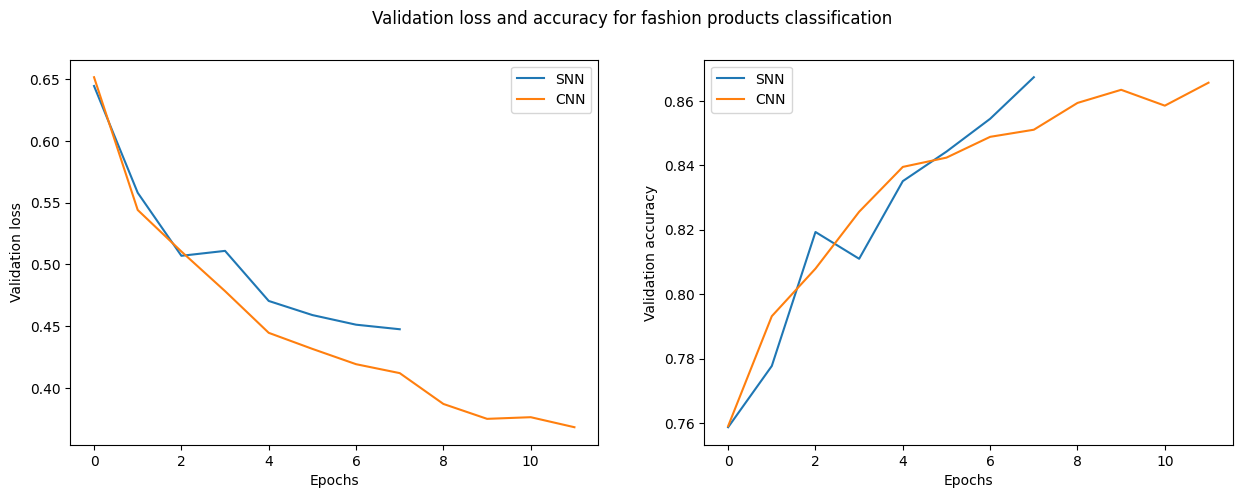

In [ ]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(fashion_snn_loss)
plt.plot(fashion_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(fashion_snn_accuracy)
plt.plot(fashion_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for fashion products classification')
plt.show()

## Results


For SOCOFing dataset SNN model outperformed the CNN model and obtained the 98% accuracy, in comparison with 83% for CNN. For both EMNIST, and Fashion-MNIST datasets SNN and CNN showed approximately the same results: 98% accuracy for EMNIST and 86% accuracy for Fashion-MNIST. However, training of one epoch for SNN was, on average, 1.5 times slower than for CNN.